# A Practice on "MovieLens 100K Dataset": #2 Baseline Models

Baseline models are important for 2 key reaons:
1. Baseline models give us a starting point to which to compare all future models, and
2. Smart baselines/averages may be needed to fill in missing data for more complicated models

Here, we'll explore a few typical baseline models for recommender systems and see which ones do the best for our dataset.

# 0. Mount and load raw data

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
cd /gdrive/MyDrive/Lectures/2023/RecSys

[Errno 2] No such file or directory: 'cd /gdrive/MyDrive/Lectures/2023/RecSys'
/content


# 1. Import necessary modules and classes

In [3]:
# <!-- collapse=True -->
%matplotlib inline
from collections import OrderedDict
from datetime import datetime
from IPython.display import Markdown
from os.path import join
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-darkgrid')

<ipython-input-3-be7ef92a9304>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# 1. Load the Data

Let's load and examine the ratings data. If you're following along (i.e. actually running these notebooks) you'll need to make sure to run the first one to download the data before running this one.

In [4]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None, 
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

FileNotFoundError: ignored

# 2. Test Baseline Models

With all that framework setup out of the way, let's evaluate a few baseline models in increasing order of expected accuracy.



## 2.1 Simple Average Model

The first model we'll test is about the simplest one possible. We'll just average all the training set ratings and use that average for the prediction for all test set examples.

In [5]:
# <!-- collapse=True -->
class SimpleAverageModel():
    """A very simple model that just uses the average of the ratings in the
    training set as the prediction for the test set.

    Attributes
    ----------
    mean : float
        Average of the training set ratings
    """

    def __init__(self):
        pass

    def fit(self, X):
        """Given a ratings dataframe X, compute the mean rating
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_ratings, >=3)
            User, item, rating dataframe. Only the 3rd column is used.
        
        Returns
        -------
        self
        """
        self.mean = X.iloc[:, 2].mean()
        return self

    def predict(self, X):
        return np.ones(len(X)) * self.mean

## 2.2 Average by ID Model

We can probably do a little better by using the user or item (movie) average. Here we'll set up a baseline model class that allows you to pass either a list of `userId`s or `movieId`s as `X`. The prediction for a given ID will just be the average of ratings from that ID, or the overall average if that ID wasn't seen in the training set.

In [ ]:
# <!-- collapse=True -->
class AverageByIdModel():
    """Simple model that predicts based on average ratings for a given Id
    (movieId or userId) from training data
    
    Parameters
    ----------
    id_column : string
        Name of id column (i.e. 'itemId', 'userId') to average by in
        dataframe that will be fitted to

    Attributes
    ----------
    averages_by_id : pandas Series, shape = [n_ids]
        Pandas series of rating averages by id
    overall_average : float
        Average rating over all training samples
    """
    def __init__(self, id_column):
        self.id_column = id_column

    def fit(self, X):
        """Fit training data.

        Parameters
        ----------
        X : pandas dataframe, shape = (n_ratings, >=3)
            User, item, rating dataframe. Columns beyond 3 are ignored

        Returns
        -------
        self : object
        """
        rating_column = X.columns[2]
        X = X[[self.id_column, rating_column]].copy()
        X.columns = ['id', 'rating']
        self.averages_by_id = (
            X
            .__TODO__ # TODO: prepare to calculate mean rating for each id.
            .mean()
            .rename('average_rating')
        )
        self.overall_average = X['rating'].mean()
        return self

    def predict(self, X):
        """Return rating predictions

        Parameters
        ----------
        X : pandas dataframe, shape = (n_ratings, >=3)
            Array of n_ratings movieIds or userIds

        Returns
        -------
        y_pred : numpy array, shape = (n_ratings,)
            Array of n_samples rating predictions
        """
        rating_column = X.columns[2]
        X = X[[self.id_column, rating_column]].copy()
        X.columns = ['id', 'rating']
        X = X.__TODO__ # joining the fitted value with the key 'id'
        X['average_rating'].fillna(__TODO__) # fill the missing values by overall_average
        return X['average_rating'].values

## 2.3 Damped Baseline with User + Movie Data

This baseline model takes into account the average ratings of both the user and the movie, as well as a damping factor that brings the baseline prediction closer to the overall mean. The damping factor has been shown empirically to improve the perfomance.

This model follows equation 2.1 from a [collaborative filtering paper](http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf) from [GroupLens](https://grouplens.org/), the same group that published the MovieLens data. This equation defines rhe baseline rating for user $u$ and item $i$ as 

$$b_{u,i} = \mu + b_u + b_i$$

where

$$b_u = \frac{1}{|I_u| + \beta_u}\sum_{i \in I_u} (r_{u,i} - \mu)$$

and

$$b_i = \frac{1}{|U_i| + \beta_i}\sum_{u \in U_i} (r_{u,i} - b_u - \mu).$$

(See equations 2.4 and 2.5). Here, $\beta_u$ and $\beta_i$ are damping factors, for which the paper reported 25 is a good number for this dataset. For now we'll just leave these values equal ($\beta=\beta_u=\beta_i$). Here's a summary of the meanings of all the variables here:

| Variable        | Meaning                                               |
| --------------- | ----------------------------------------------------- |
| $b_{u,i}$       | Baseline rating for user $u$ on item (movie) $i$      |
| $\mu$           | The mean of all ratings                               |
| $b_u$           | The deviation from $\mu$ associated with user $u$     |
| $b_i$           | The deviation from $\mu+b_u$ associated with user $i$ |
| $I_u$           | The set of all items rated by user $u$                |
| $\mid I_u \mid$ | The number of items rated by user $u$                 |
| $\beta_u$       | Damping factor for the users ($=\beta$)               |
| $r_{u,i}$       | Observed rating for user $u$ on item $i$              |
| $U_i$           | The set of all users who rated item $i$               |
| $\mid U_i \mid$ | The number of users who rated item $i$                |
| $\beta_i$       | Damping factor for the items ($=\beta$)               |

In [ ]:
# <!-- collapse=True -->
class DampedUserMovieBaselineModel():
    """Baseline model that of the form mu + b_u + b_i,
    where mu is the overall average, b_u is a damped user
    average rating residual, and b_i is a damped item (movie)
    average rating residual. See eqn 2.1 of
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf

    Parameters
    ----------
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be positive.

    Attributes
    ----------
    mu : float
        Average rating over all training samples
    b_u : pandas Series, shape = [n_users]
        User residuals
    b_i : pandas Series, shape = [n_movies]
        Movie residuals
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be >= 0.
    """
    def __init__(self, damping_factor=0):
        self.damping_factor = damping_factor

    def fit(self, X):
        """Fit training data.

        Parameters
        ----------
        X : DataFrame, shape = [n_samples, >=3]
            User, movie, rating dataFrame. Columns beyond 3 are ignored

        Returns
        -------
        self : object
        """
        X = X.iloc[:, :3].copy()
        X.columns = ['user', 'item', 'rating']
        self.mu = np.mean(X['rating'])
        user_counts = X['user'].value_counts()
        movie_counts = X['item'].value_counts()
        b_u = (
            X[['user', 'rating']]
            .groupby('user')['rating']
            .sum()
            .subtract(user_counts * self.mu)
            .divide(user_counts + self.damping_factor) # Question: Tell me the meaning of this expresison.
            .rename('b_u')
        )
        X = X.join(b_u, on='user')
        X['item_residual'] = X['rating'] - X['b_u'] - self.mu
        b_i = (
            X[['item', 'item_residual']]
            .groupby('item')['item_residual']
            .sum()
            .divide(movie_counts + self.damping_factor)
            .rename('b_i')
        )
        self.b_u = b_u
        self.b_i = b_i
        return self

    def predict(self, X):
        """Return rating predictions

        Parameters
        ----------
        X : DataFrame, shape = (n_ratings, 2)
            User, item dataframe

        Returns
        -------
        y_pred : numpy array, shape = (n_ratings,)
            Array of n_samples rating predictions
        """
        X = X.iloc[:, :2].copy()
        X.columns = ['user', 'item']
        X = X.join(self.b_u, on='user').fillna(0)
        X = X.join(self.b_i, on='item').fillna(0)
        return (self.mu + X['b_u'] + X['b_i']).values

## 2.4 Cross-validation framework

Because the ratings distributions look relatively unchanged over time, we will use a time-independent cross-validation framework to determine the best baseline model moving forward. Below we define `get_xval_errs()` such that if you pass in a dataframe and a baseline model object, it will return a list of the 5 (or `n_splits`) Mean Absolute Error (MAE) values from each fold.

In [ ]:
def get_xval_errs_and_res(df, model, n_splits=5, random_state=0, rating_col='rating'):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    errs, stds = [], []
    residuals = np.zeros(len(df))
    for train_inds, test_inds in kf.split(df):
        train_df, test_df = df.iloc[train_inds], df.iloc[test_inds]
        pred = model.fit(train_df).predict(test_df)
        residuals[test_inds] = pred - test_df[rating_col]
        mae = mean_absolute_error(pred, test_df[rating_col])
        errs.append(mae)
    return errs, residuals

In [ ]:
# <!-- collapse=True -->
errs_1, res_1 = get_xval_errs_and_res(ratings_df, SimpleAverageModel())
errs_2, res_2 = get_xval_errs_and_res(ratings_df, AverageByIdModel('movieId'))
errs_3, res_3 = get_xval_errs_and_res(ratings_df, AverageByIdModel('userId'))
errs_4, res_4 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(0))
errs_5, res_5 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(10))
errs_6, res_6 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(25))
errs_7, res_7 = get_xval_errs_and_res(ratings_df, DampedUserMovieBaselineModel(50))
df_errs = pd.DataFrame(
    OrderedDict(
        (
            ('Average', errs_1),
            ('Item Average', errs_2),
            ('User Average', errs_3),
            ('Combined 0', errs_4),
            ('Combined 10', errs_5),
            ('Combined 25', errs_6),
            ('Combined 50', errs_7),
        )
    )
)
display(df_errs)
df_errs = (
    pd.melt(df_errs, value_vars=df_errs.columns)
    .rename({'variable': 'Baseline Model', 'value': 'MAE'}, axis=1)
)
df_res = pd.DataFrame(
    OrderedDict(
        (
            ('Average', res_1),
            ('Item Average', res_2),
            ('User Average', res_3),
            ('Combined 0', res_4),
            ('Combined 10', res_5),
            ('Combined 25', res_6),
            ('Combined 50', res_7),
        )
    )
)
display(df_res.tail())
df_res = (
    pd.melt(df_res, value_vars=df_res.columns)
    .rename({'variable': 'Baseline Model', 'value': 'Residual'}, axis=1)
)

,Average,Item Average,User Average,Combined 0,Combined 10,Combined 25,Combined 50
0,0.939162,0.811269,0.831298,0.755430,0.755464,0.762167,0.773878
1,0.953546,0.825826,0.842123,0.763357,0.764607,0.772311,0.784917
2,0.945203,0.814170,0.837097,0.756930,0.757058,0.764222,0.776594
3,0.937805,0.813379,0.829088,0.752296,0.752067,0.759184,0.771438
4,0.947789,0.820584,0.835703,0.759446,0.758596,0.765727,0.778640


,Average,Item Average,User Average,Combined 0,Combined 10,Combined 25,Combined 50
99995,-0.469962,-0.818182,-1.312500,-1.685783,-1.309823,-1.064157,-0.879818
99996,0.529250,1.257840,-0.250000,0.470316,0.745904,0.889564,0.957743
99997,0.529250,0.431718,-0.250000,-0.316540,-0.013689,0.165553,0.285235
99998,-0.469725,-0.850202,-1.222222,-1.576254,-1.297059,-1.111336,-0.969531
99999,-0.469962,0.222222,-1.312500,-0.585790,-0.313548,-0.185631,-0.140242


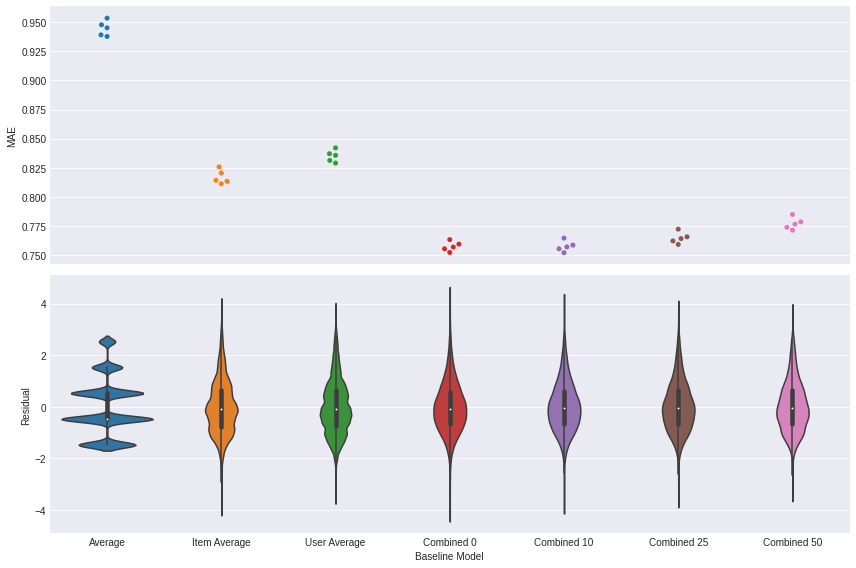

In [ ]:
# <!-- collapse=True -->
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8))
sns.swarmplot(data=df_errs, x='Baseline Model', y='MAE', ax=ax0)
sns.violinplot(data=df_res, x='Baseline Model', y='Residual', ax=ax1)
ax0.xaxis.set_visible(False)
plt.tight_layout()
plt.show()

The MAE plots above show that the combined model with a damping factor of 0 or 10 performs the best, followed by the item average, then the user average. It makes sense that taking into account deviations from the mean due to both user and item would perform the best: there is simply more data being taken into account for each baseline prediction. The same idea explains why the item average performs better than the user average: there are more items than users in this dataset, so averaging over items takes into account more data per baseline prediction than averaging over users. The residual plots underneath the MAE plot illustrate that taking into account more data pulls the density of the residuals closer to 0.

Before moving on to collaborative filtering models, we'll want to choose which model to use as a baseline. Both the Combined 0 and Combined 10 models performed equally, but we'll choose the Combined 10 model, because a higher damping factor is effectively stronger regularization, which will prevent overfitting better than a damping factor of 0.

Check out the next post/notebook to see collaborative filtering models building on these baselines!